# Тестовое задание
Ваша задача написать пайплайн для тренировки модели глубоко обучения (любую – **embeddings + LSTM, Bert** …) с использованием следующих инструментов: pytorch, sklearn, matplotlib – для решения задачи **NER** (извлечения сущностей).

В качестве данных используется датасет **Conll2003** с четырьмя классами **Per, Org, Loc, Misc** в формате **Conll**.

В тетрадке ниже заданы основные классы и функции для построения требуемого пайплайн, какие-то уже имплементированы, какие-то – нет. Их требуется доработать. Тем не менее если данный набор абстракций вам не подходит Вы можете написать свой пайплайн «с нуля», однако обоснованность у этих действий должна быть.

### Что оценивается в первую очередь:

* Выбранная архитектура для решения задачи
* Выбранные предобученные веса
* Полученные метрики
### Затем:

* Глубина разведочного анализа
* Какая схема теггирования используется (**BIO, IO** или другие)
* Каким образом производится расчет метрик (потокенный отчет, отчет по точному совпадению спанов сущностей)
### С меньшим приоритетом:

* Скорость предобработки и постобработки данных
* Стиль кода

In [40]:
import numpy as np

In [41]:
a = [[1, 2, 3], [4,2, 5]]

b = [x for y in a for x in y]
print(a, b)

[[1, 2, 3], [4, 2, 5]] [1, 2, 3, 4, 2, 5]


In [42]:
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train

--2021-05-25 19:28:30--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 827012 (808K) [text/plain]
Saving to: ‘eng.testa.1’

eng.testa.1         100%[===================>] 807.63K  --.-KB/s    in 0.04s   

2021-05-25 19:28:30 (19.7 MB/s) - ‘eng.testa.1’ saved [827012/827012]

--2021-05-25 19:28:30--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3281528 (3.1M) [text/plai

In [43]:
!head eng.train

-DOCSTART- -X- O O

EU NNP I-NP I-ORG
rejects VBZ I-VP O
German JJ I-NP I-MISC
call NN I-NP O
to TO I-VP O
boycott VB I-VP O
British JJ I-NP I-MISC
lamb NN I-NP O


In [44]:
import torch
from torch.utils.data import Dataset, DataLoader
from typing import List
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from torch import nn
from sklearn.metrics import classification_report

In [45]:
def read_data(file):
    lines = open(file, "r").readlines()
    data = {"sentences": [], "labels_per_sent": []}
    sentence, labels = [], []
    for line in tqdm(lines):
        line = line.strip()
        if not line:
            if sentence and labels:
                assert len(sentence) == len(labels)
                data["sentences"].append(sentence)
                data["labels_per_sent"].append(labels)
                sentence, labels = [], []
            continue
        if line.startswith("-DOCSTART-"):
            continue
        else:
            values = line.split(" ")
            try:
                token, _, _, label = values
                sentence.append(token)
                if label != 'O':
                    labels.append(label.split('-')[-1])
                else:
                    labels.append(label)

            except Exception as e:
                print(f"Error has occur: {e}")
                continue
    return data


train = read_data("eng.train")
valid = read_data("eng.testa")

100%|██████████| 55045/55045 [00:00<00:00, 712778.79it/s]


In [46]:
valid["sentences"][0], valid["labels_per_sent"][0]

(['CRICKET',
  '-',
  'LEICESTERSHIRE',
  'TAKE',
  'OVER',
  'AT',
  'TOP',
  'AFTER',
  'INNINGS',
  'VICTORY',
  '.'],
 ['O', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])

In [47]:
def get_label_distribution(labels: List[List[str]]):
    labels = [label for labels_per_sent in labels for label in labels_per_sent]
    return Counter(labels)

In [48]:
train_distribution = get_label_distribution(train["labels_per_sent"])
valid_distribution = get_label_distribution(valid["labels_per_sent"])

In [49]:
train_distribution, valid_distribution

(Counter({'LOC': 8297, 'MISC': 4593, 'O': 169578, 'ORG': 10025, 'PER': 11128}),
 Counter({'LOC': 2094, 'MISC': 1268, 'O': 42759, 'ORG': 2092, 'PER': 3149}))

Train distribution


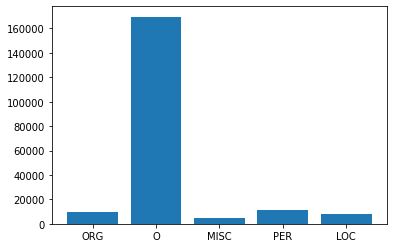

Valid distribution


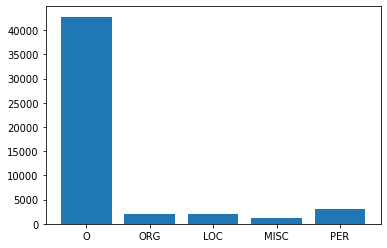

In [50]:
def visualize_distr(data: Counter):
    labels = list(data.keys())
    plt.bar(x=labels, height=list(data.values()))
    plt.show()


print("Train distribution")
visualize_distr(train_distribution)
print("Valid distribution")
visualize_distr(valid_distribution)

### Посмотрим на баланс классов целевых сущностей (без 'O')

In [51]:
ne_tags_train = list(train_distribution.keys())               # извлекаем сущности из трейн-части
idx_O_train = ne_tags_train.index('O')
counts_ne_tags_train = list(train_distribution.values())

ne_tags_train.remove('O')                                     # удаляем 'O'
counts_ne_tags_train.pop(idx_O_train)


ne_tags_valid = list(valid_distribution.keys())               # извлекаем сущности из валид-части
idx_O_valid = ne_tags_valid.index('O')
counts_ne_tags_valid = list(valid_distribution.values())

ne_tags_valid.remove('O')                                     # удаляем 'O'
counts_ne_tags_valid.pop(idx_O_valid)

ne_tags_train, counts_ne_tags_train = zip(*sorted(zip(ne_tags_train, counts_ne_tags_train)))
ne_tags_valid, counts_ne_tags_valid = zip(*sorted(zip(ne_tags_valid, counts_ne_tags_valid)))

ne_tags, counts_ne_tags = [], []
ne_tags.append(ne_tags_train)
ne_tags.append(ne_tags_valid)
counts_ne_tags.append(counts_ne_tags_train)
counts_ne_tags.append(counts_ne_tags_valid)

class_data = ['train', 'valid']

In [52]:
print(ne_tags, counts_ne_tags)

[('LOC', 'MISC', 'ORG', 'PER'), ('LOC', 'MISC', 'ORG', 'PER')] [(8297, 4593, 10025, 11128), (2094, 1268, 2092, 3149)]


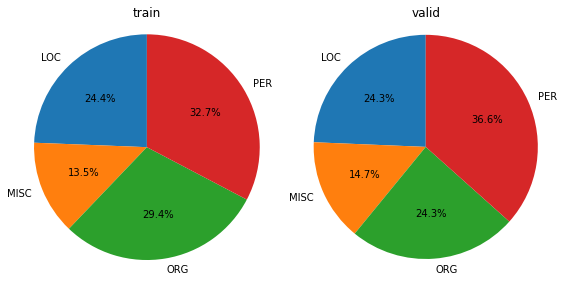

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  
                                                              
for j, ax in enumerate(axes.flat):                            
        
    ax.set_title(class_data[j])                         
    ax.pie(counts_ne_tags[j], labels=ne_tags[j], autopct='%1.1f%%', startangle=90)
    ax.axis('equal')

plt.tight_layout()
plt.show()

Сильного дисбаланса в данных не наблюдается

### Попробуем применить BIO-тегирование

In [54]:
def bio_tagger(tags):
      bio_tagged = []
      prev_tag = "O"
      for tag in tags:
          if tag == "O":                            #O
              bio_tagged.append(tag)
              prev_tag = tag
              continue
          if tag != "O" and prev_tag == "O":        # Begin NE
              bio_tagged.append("B-"+tag)
              prev_tag = tag
          elif prev_tag != "O" and prev_tag == tag: # Inside NE
              bio_tagged.append("I-"+tag)
              prev_tag = tag
          elif prev_tag != "O" and prev_tag != tag: # Adjacent NE
              bio_tagged.append("B-"+tag)
              prev_tag = tag
      return bio_tagged

In [55]:
# Получим тегированные лейблы для данных
train["labels_per_sent"] = [bio_tagger(labs) for labs in train["labels_per_sent"]]
valid["labels_per_sent"] = [bio_tagger(labs) for labs in valid["labels_per_sent"]]

Посмотрим, как тегировались лейблы

In [56]:
print(train["labels_per_sent"][0], train['sentences'][0])

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O'] ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']


Более сложный вариант

In [65]:
print(train["labels_per_sent"][8], train['sentences'][8])

['B-PER', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O'] ['Fischler', 'proposed', 'EU-wide', 'measures', 'after', 'reports', 'from', 'Britain', 'and', 'France', 'that', 'under', 'laboratory', 'conditions', 'sheep', 'could', 'contract', 'Bovine', 'Spongiform', 'Encephalopathy', '(', 'BSE', ')', '--', 'mad', 'cow', 'disease', '.']


И распределение новых классов

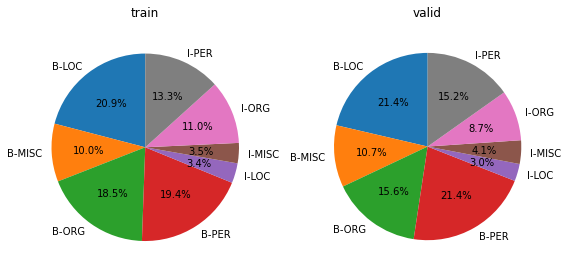

In [57]:
train_distribution = get_label_distribution(train["labels_per_sent"])
valid_distribution = get_label_distribution(valid["labels_per_sent"])

ne_tags_train = list(train_distribution.keys())               # извлекаем сущности из трейн-части
idx_O_train = ne_tags_train.index('O')
counts_ne_tags_train = list(train_distribution.values())

ne_tags_train.remove('O')                                     # удаляем 'O'
counts_ne_tags_train.pop(idx_O_train)


ne_tags_valid = list(valid_distribution.keys())               # извлекаем сущности из валид-части
idx_O_valid = ne_tags_valid.index('O')
counts_ne_tags_valid = list(valid_distribution.values())

ne_tags_valid.remove('O')                                     # удаляем 'O'
counts_ne_tags_valid.pop(idx_O_valid)

ne_tags_train, counts_ne_tags_train = zip(*sorted(zip(ne_tags_train, counts_ne_tags_train)))
ne_tags_valid, counts_ne_tags_valid = zip(*sorted(zip(ne_tags_valid, counts_ne_tags_valid)))

ne_tags, counts_ne_tags = [], []
ne_tags.append(ne_tags_train)
ne_tags.append(ne_tags_valid)
counts_ne_tags.append(counts_ne_tags_train)
counts_ne_tags.append(counts_ne_tags_valid)

class_data = ['train', 'valid']

fig, axes = plt.subplots(1, 2, figsize=(8, 4))  
                                                              
for j, ax in enumerate(axes.flat):                            
        
    ax.set_title(class_data[j])                         
    ax.pie(counts_ne_tags[j], labels=ne_tags[j], autopct='%1.1f%%', startangle=90)
    ax.axis('equal')

plt.tight_layout()
plt.show()

Можно заметить, что примерно 2/3 сущностей состоят из одного токена

In [19]:
!pip install transformers

     |████████████████████████████████| 2.3MB 11.1MB/s 
     |████████████████████████████████| 901kB 34.7MB/s 
     |████████████████████████████████| 3.3MB 34.1MB/s 


In [20]:
from transformers import BertForTokenClassification, BertTokenizer#, DistilBertModel, DistilBertTokenizer 

pretrained_model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=10)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# pretrained_model = DistilBertModel.from_pretrained('distilbert-base-uncased', num_labels=9)
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

In [24]:
class NERDataset(Dataset):

    def __init__(self, data, tokenizer=tokenizer, max_length=200):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.labels = np.unique([x for y in self.data["labels_per_sent"] for x in y])
        self.label2num = {l: num+1 for num, l in enumerate(self.labels)}

    def __getitem__(self, index):
        sent = " ".join(self.data['sentences'][index])
        labels_per_sent = self.data["labels_per_sent"][index]

        tokenizer_output = self.tokenizer.encode_plus(
                            sent,
                            None,
                            add_special_tokens=True,
                            max_length=self.max_length,
                            padding='max_length',
                            return_token_type_ids=True
        )

        target =  [self.label2num[k] for k in labels_per_sent]
        target.extend([0]*self.max_length)                      # 0 соответствует кодированному лейблу паддинга
        target=target[:self.max_length]

        
        return {
            "input_ids": torch.tensor(tokenizer_output['input_ids'], dtype=torch.long).squeeze(0),
            'token_type_ids': torch.tensor(tokenizer_output['token_type_ids'], dtype=torch.long).squeeze(0),
            "attention_mask": torch.tensor(tokenizer_output['attention_mask'], dtype=torch.long).squeeze(0),
            'labels': torch.tensor(target, dtype=torch.long).squeeze(0) 
        }

    def __len__(self):
        return len(self.data["sentences"])


train_dataset = NERDataset(train)
valid_dataset = NERDataset(valid)

In [31]:
b = train_dataset.label2num
print(f'Кодировка лейблов:\n{b}')

Кодировка лейблов:
{'B-LOC': 1, 'B-MISC': 2, 'B-ORG': 3, 'B-PER': 4, 'I-LOC': 5, 'I-MISC': 6, 'I-ORG': 7, 'I-PER': 8, 'O': 9}


In [32]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [34]:
class NERModel(nn.Module):

    def __init__(self, pretrained_model):#, dropout=0.1):
        super().__init__()

        self.bert = pretrained_model
        # self.dropout = nn.Dropout(p=dropout)
        # self.relu = nn.ReLU()

        # self.fc_1 = nn.Linear(200, 2048)
        # self.fc_2 = nn.Linear(2048, 9)
        # self.softmax = nn.Softmax()
    
    def forward(self, inputs, attention_mask, token_type_ids, labels):
        
        outputs = self.bert(input_ids=inputs, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
        # x = self.relu(self.fc_1(outputs[0][:, 0, :]))
        # x = self.fc_2(self.dropout(x))
        # probs = self.softmax(x)
        # loss = nn.CrossEntropyLoss(ignore_index=0)(outputs.squeeze(1), labels)
       
        return outputs[0], outputs[1] #loss, probs

In [35]:
device = "cuda:0"
print(device)

cuda:0


In [36]:
import torch.optim as optim

model = NERModel(pretrained_model)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

In [37]:
def transform_logits(predictions: List[torch.tensor]):
    return np.argmax(predictions.detach().cpu().numpy(), axis=2).flatten()

def transform_target(target_labels: List[torch.tensor]):
    return target_labels.to('cpu').numpy().flatten()

In [38]:
def count_metrics(gold_labels_per_sentence: List[List[str]], predict_labels_per_sentence: List[List[str]]):
    gold_labels = [l for l_per_sent in gold_labels_per_sentence for l in l_per_sent]
    predict_labels = [l for l_per_sent in predict_labels_per_sentence for l in l_per_sent]
    print(classification_report(gold_labels, predict_labels))

In [39]:
from tqdm.notebook import tqdm

losses = {"train_losses": [], "valid_losses": []}
train_history = []    # Для отрисовки графиков
valid_history = []    # - // - // -

epochs = 10
clip = 1
epoch_loss_train = 0  # Для отрисовки графиков
epoch_loss_valid = 0  # - // - // -

for epoch in range(epochs):

    print(f"Start epoсh #{epoch}")
    model.train()
    for i, train_batch in enumerate(tqdm(train_dataloader)):

        input_ids = train_batch['input_ids'].to(device)
        attention_mask = train_batch['attention_mask'].to(device)
        labels = train_batch['labels'].to(device)
        token_type_ids = train_batch['token_type_ids'].to(device)

        optimizer.zero_grad()
        loss, logits = model.forward(input_ids, attention_mask, token_type_ids, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss_train += loss.item()
        losses["train_losses"].append(loss)



    predict_labels, gold_labels = [], []

    model.eval()

    for valid_batch in tqdm(valid_dataloader):

        with torch.no_grad():
            input_ids = valid_batch['input_ids'].to(device)
            attention_mask = valid_batch['attention_mask'].to(device)
            labels = valid_batch['labels'].to(device)
            token_type_ids = valid_batch['token_type_ids'].to(device)
            
            
            loss, logits = model.forward(input_ids, attention_mask, token_type_ids, labels)
            epoch_loss_valid += loss.item()
            losses["valid_losses"].append(loss)

            gold_labels.append(transform_target(labels))
            predict_labels.append(transform_logits(logits))

    train_history.append(epoch_loss_train/(i+1))
    valid_history.append(epoch_loss_valid/(i+1))
    count_metrics(gold_labels, predict_labels)
  
    print(f"End eposh #{epoch}")

Start epoсh #0



              precision    recall  f1-score   support

           0       1.00      0.74      0.85    598638
           1       0.16      0.51      0.25      1837
           2       0.47      0.22      0.30       918
           3       0.31      0.46      0.37      1341
           4       0.29      0.47      0.36      1842
           5       0.62      0.37      0.46       257
           6       0.76      0.09      0.16       350
           7       0.49      0.41      0.45       751
           8       0.30      0.45      0.36      1307
           9       0.21      0.96      0.35     42759

    accuracy                           0.75    650000
   macro avg       0.46      0.47      0.39    650000
weighted avg       0.94      0.75      0.81    650000

End eposh #0
Start epoсh #1



              precision    recall  f1-score   support

           0       1.00      0.71      0.83    598638
           1       0.16      0.67      0.26      1837
           2       0.15      0.47      0.23       918
           3       0.15      0.65      0.24      1341
           4       0.25      0.55      0.34      1842
           5       0.86      0.45      0.59       257
           6       0.35      0.44      0.39       350
           7       0.29      0.54      0.38       751
           8       0.23      0.56      0.33      1307
           9       0.20      0.96      0.34     42759

    accuracy                           0.72    650000
   macro avg       0.36      0.60      0.39    650000
weighted avg       0.94      0.72      0.79    650000

End eposh #1
Start epoсh #2



              precision    recall  f1-score   support

           0       1.00      0.64      0.78    598638
           1       0.17      0.74      0.28      1837
           2       0.14      0.54      0.22       918
           3       0.14      0.71      0.23      1341
           4       0.20      0.70      0.31      1842
           5       0.65      0.56      0.60       257
           6       0.20      0.61      0.30       350
           7       0.20      0.68      0.30       751
           8       0.19      0.72      0.30      1307
           9       0.18      0.95      0.30     42759

    accuracy                           0.66    650000
   macro avg       0.31      0.68      0.36    650000
weighted avg       0.93      0.66      0.74    650000

End eposh #2
Start epoсh #3



              precision    recall  f1-score   support

           0       1.00      0.64      0.78    598638
           1       0.13      0.83      0.23      1837
           2       0.12      0.67      0.21       918
           3       0.11      0.76      0.19      1341
           4       0.19      0.76      0.31      1842
           5       0.47      0.66      0.55       257
           6       0.23      0.63      0.34       350
           7       0.17      0.73      0.28       751
           8       0.17      0.80      0.28      1307
           9       0.18      0.94      0.30     42759

    accuracy                           0.66    650000
   macro avg       0.28      0.74      0.35    650000
weighted avg       0.93      0.66      0.74    650000

End eposh #3
Start epoсh #4



              precision    recall  f1-score   support

           0       1.00      0.61      0.75    598638
           1       0.15      0.83      0.26      1837
           2       0.15      0.68      0.25       918
           3       0.12      0.81      0.21      1341
           4       0.21      0.77      0.33      1842
           5       0.51      0.70      0.59       257
           6       0.26      0.65      0.37       350
           7       0.18      0.73      0.29       751
           8       0.19      0.76      0.31      1307
           9       0.17      0.97      0.29     42759

    accuracy                           0.63    650000
   macro avg       0.29      0.75      0.36    650000
weighted avg       0.93      0.63      0.72    650000

End eposh #4
Start epoсh #5



              precision    recall  f1-score   support

           0       1.00      0.59      0.74    598638
           1       0.14      0.83      0.24      1837
           2       0.14      0.71      0.23       918
           3       0.11      0.81      0.20      1341
           4       0.19      0.79      0.31      1842
           5       0.30      0.80      0.44       257
           6       0.20      0.72      0.31       350
           7       0.19      0.74      0.31       751
           8       0.18      0.77      0.30      1307
           9       0.17      0.97      0.28     42759

    accuracy                           0.62    650000
   macro avg       0.26      0.77      0.34    650000
weighted avg       0.93      0.62      0.71    650000

End eposh #5
Start epoсh #6



              precision    recall  f1-score   support

           0       1.00      0.59      0.74    598638
           1       0.15      0.83      0.26      1837
           2       0.14      0.75      0.23       918
           3       0.11      0.82      0.19      1341
           4       0.20      0.79      0.32      1842
           5       0.39      0.77      0.52       257
           6       0.19      0.71      0.30       350
           7       0.17      0.75      0.28       751
           8       0.16      0.79      0.27      1307
           9       0.16      0.97      0.28     42759

    accuracy                           0.62    650000
   macro avg       0.27      0.78      0.34    650000
weighted avg       0.93      0.62      0.70    650000

End eposh #6
Start epoсh #7



              precision    recall  f1-score   support

           0       1.00      0.59      0.74    598638
           1       0.12      0.85      0.22      1837
           2       0.14      0.73      0.23       918
           3       0.10      0.82      0.18      1341
           4       0.21      0.82      0.33      1842
           5       0.40      0.80      0.53       257
           6       0.22      0.70      0.33       350
           7       0.19      0.75      0.30       751
           8       0.16      0.81      0.27      1307
           9       0.17      0.97      0.29     42759

    accuracy                           0.62    650000
   macro avg       0.27      0.78      0.34    650000
weighted avg       0.93      0.62      0.71    650000

End eposh #7
Start epoсh #8



              precision    recall  f1-score   support

           0       1.00      0.58      0.74    598638
           1       0.14      0.85      0.24      1837
           2       0.12      0.78      0.21       918
           3       0.12      0.82      0.21      1341
           4       0.19      0.83      0.31      1842
           5       0.35      0.78      0.49       257
           6       0.19      0.72      0.30       350
           7       0.16      0.76      0.26       751
           8       0.18      0.79      0.29      1307
           9       0.16      0.98      0.28     42759

    accuracy                           0.61    650000
   macro avg       0.26      0.79      0.33    650000
weighted avg       0.93      0.61      0.70    650000

End eposh #8
Start epoсh #9



              precision    recall  f1-score   support

           0       1.00      0.57      0.73    598638
           1       0.15      0.87      0.26      1837
           2       0.12      0.78      0.21       918
           3       0.11      0.83      0.19      1341
           4       0.19      0.80      0.31      1842
           5       0.33      0.82      0.47       257
           6       0.18      0.75      0.29       350
           7       0.16      0.77      0.26       751
           8       0.16      0.82      0.27      1307
           9       0.16      0.97      0.27     42759

    accuracy                           0.60    650000
   macro avg       0.26      0.80      0.33    650000
weighted avg       0.93      0.60      0.69    650000

End eposh #9


### График обучения модели

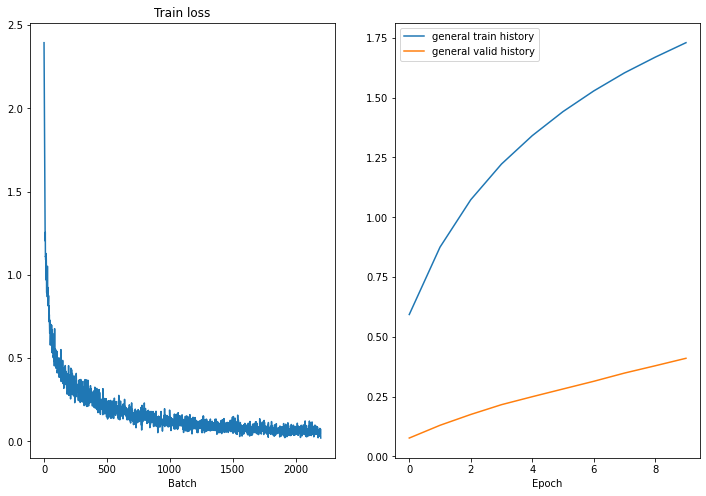

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

ax[0].plot(losses["train_losses"], label='train loss')
ax[0].set_xlabel('Batch')
ax[0].set_title('Train loss')

ax[1].plot(train_history, label='general train history')
ax[1].set_xlabel('Epoch')

ax[1].plot(valid_history, label='general valid history')

plt.legend()
plt.show()

## Заключение

Ключевым критерием в задаче NER является F1-метрика, которая является средним гармоническим (компромиссным вариантом) между точностью и полнотой.

В текущем задании на 10 эпохах получились не самые лучшие значения метрики при потокенном подсчёте, что можно было бы объяснить:
* не самым удачным выбором весов и самой BERT-модели;
* введением лейбла паддинга 0, который сильно смещает баланс классов в свою сторону.

P.S. К сожалению, не хватило времени попробовать больше, поэтому оставлю комментарий. Поскольку выбранная модель уже содержит в себе классификатор и функцию ошибок, то скорректировать не удалось. Можно было бы попробовать применить, например, облегчённый DistilBertModel с соответствующими ему токенизатором и весами. По идее учился бы он быстрее, и можно было бы попробовать больше эпох. Плюс пришлось бы использовать свой классификатор, например, из двух линейных слоёв и самому прописывать лосс (nn.CrossEntropy), где можно было бы как раз игнорировать класс паддинга через ignore_index=0.